# Figures for Thesis Results

This notebook aggregates pulse outputs from CMA-ES and GRAPE runs, resamples them to a shared time grid, and rescales the pulse areas so that each Omega channel integrates to $4\pi$.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt

from pathlib import Path
from collections import defaultdict
from warnings import warn

In [2]:
BASE_DIR = Path('/home/yehon/projects/grape-crab-qoc')
RESULT_DIRS = {
    'CMA-ES': BASE_DIR / 'notebooks' / 'results' / 'CMA-ES',
    'GRAPE': BASE_DIR / 'notebooks' / 'results' / 'GRAPE',
}
OUTPUT_DIR = BASE_DIR / 'results' / 'results'

CANONICAL_DURATION = 0.1
CANONICAL_POINTS = 2000
CANONICAL_T = np.linspace(0.0, CANONICAL_DURATION, CANONICAL_POINTS)

TARGETS = ['original', 'adiabatic', 'terminal', 'ensemble']
TARGET_ALIASES = {
    'original': ['original', 'baseline'],
    'adiabatic': ['adiabatic', 'path'],
    'terminal': ['terminal', 'fidelity'],
    'ensemble': ['ensemble'],
}
CHANNELS = ['omega', 'delta']
CHANNEL_ALIASES = {
    'omega': ['omega'],
    'delta': ['delta'],
}

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts will be written to: {OUTPUT_DIR}')

Artifacts will be written to: /home/yehon/projects/grape-crab-qoc/results/results


In [3]:
COLOR_MAP = {
    'original': '#1f77b4',  # blue
    'terminal': '#ff7f0e',  # orange
    'adiabatic': '#2ca02c',  # green
    'ensemble': '#d62728',  # red
}

TARGET_DISPLAY_NAMES = {
    'original': 'Original',
    'terminal': 'Terminal',
    'adiabatic': 'Adiabatic',
    'ensemble': 'Ensemble',
}

TIME_LABEL = 'Time (us)'


def color_for(target: str) -> str:
    return COLOR_MAP.get(target, '#7f7f7f')


def display_name(target: str) -> str:
    return TARGET_DISPLAY_NAMES.get(target, target.title())

In [4]:
def iter_pulse_files(directory: Path):
    for path in directory.glob('*.npy'):
        if path.is_file():
            yield path


def resolve_pulse_file(directory: Path, target: str, channel: str) -> Path:
    target_aliases = [alias.lower() for alias in TARGET_ALIASES[target]]
    channel_aliases = [alias.lower() for alias in CHANNEL_ALIASES[channel]]
    for pulse_path in iter_pulse_files(directory):
        name = pulse_path.name.lower()
        if any(alias in name for alias in target_aliases) and any(alias in name for alias in channel_aliases):
            return pulse_path
    target_desc = ', '.join(target_aliases)
    channel_desc = ', '.join(channel_aliases)
    raise FileNotFoundError(f'No {channel} pulse for target "{target}" (aliases: {target_desc}) in {directory}')


def load_and_resample(path: Path, canonical_t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    raw = np.load(path)
    if raw.ndim != 1:
        raise ValueError(f'Expected 1D pulse in {path}, received shape {raw.shape}')
    original_t = np.linspace(canonical_t[0], canonical_t[-1], raw.size)
    resampled = np.interp(canonical_t, original_t, raw)
    return raw, resampled


def scale_pulses(omega: np.ndarray, delta: np.ndarray, canonical_t: np.ndarray) -> tuple[float, np.ndarray, np.ndarray, float, float]:
    area = np.trapezoid(omega, canonical_t)
    if np.isclose(area, 0.0):
        warn('Omega area is approximately zero; skipping rescale and leaving pulses unchanged.')
        scale = 1.0
    else:
        scale = 4 * np.pi / area
    omega_scaled = omega * scale
    delta_scaled = delta# * scale
    scaled_area = np.trapezoid(omega_scaled, canonical_t)
    return scale, omega_scaled, delta_scaled, area, scaled_area


def slugify(*parts: str) -> str:
    return '_'.join(part.lower().replace('-', '_') for part in parts)


In [5]:
resampled_pulses: dict[str, dict[str, dict[str, np.ndarray]]] = defaultdict(dict)
summary_rows: list[dict[str, float]] = []
missing_entries: list[str] = []

for algorithm, directory in RESULT_DIRS.items():
    if not directory.exists():
        warn(f'Skipping {algorithm}: directory {directory} not found.')
        continue
    for target in TARGETS:
        try:
            omega_path = resolve_pulse_file(directory, target, 'omega')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | omega')
            warn(str(exc))
            continue
        try:
            delta_path = resolve_pulse_file(directory, target, 'delta')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | delta')
            warn(str(exc))
            continue

        _, omega_resampled = load_and_resample(omega_path, CANONICAL_T)
        _, delta_resampled = load_and_resample(delta_path, CANONICAL_T)

        scale, omega_scaled, delta_scaled, area_before, area_after = scale_pulses(
            omega_resampled, delta_resampled, CANONICAL_T
        )

        resampled_pulses[algorithm][target] = {
            'omega': omega_scaled,
            'delta': delta_scaled,
            'scale_factor': scale,
            'area_before': area_before,
            'area_after': area_after,
        }

        summary_rows.append(
            {
                'algorithm': algorithm,
                'target': target,
                'omega_file': omega_path.name,
                'delta_file': delta_path.name,
                'scale_factor': scale,
                'area_before': area_before,
                'area_after': area_after,
            }
        )

summary_df = pd.DataFrame(summary_rows)
summary_df

,algorithm,target,omega_file,delta_file,scale_factor,area_before,area_after
0,CMA-ES,original,Omega_Original.npy,Delta_Original.npy,1.000000,12.566370,12.566371
1,CMA-ES,adiabatic,Omega_Adiabatic.npy,Delta_Adiabatic.npy,1.223037,10.274726,12.566371
2,CMA-ES,terminal,Omega_Fidelity.npy,Delta_Fidelity.npy,1.058868,11.867735,12.566371
3,CMA-ES,ensemble,Omega_Ensemble.npy,Delta_Ensemble.npy,1.022446,12.290504,12.566371
4,GRAPE,original,OMEGA_baseline.npy,DELTA_baseline.npy,1.000000,12.566367,12.566371
5,GRAPE,adiabatic,OMEGA_path.npy,DELTA_path.npy,1.138493,11.037723,12.566371
6,GRAPE,terminal,OMEGA_terminal.npy,DELTA_terminal.npy,1.023007,12.283759,12.566371
7,GRAPE,ensemble,OMEGA_ensemble.npy,DELTA_ensemble.npy,1.136607,11.056037,12.566371


In [6]:
for algorithm, targets_dict in resampled_pulses.items():
    if not targets_dict:
        continue
    data = {'t': CANONICAL_T}
    for target, pulse_dict in targets_dict.items():
        slug = slugify(target)
        data[f'{slug}_omega'] = pulse_dict['omega']
        data[f'{slug}_delta'] = pulse_dict['delta']
    output_path = OUTPUT_DIR / f'{slugify(algorithm)}_rescaled_pulses.npz'
    np.savez(output_path, **data)
    print(f'Saved {output_path}')

summary_path = OUTPUT_DIR / 'pulse_scaling_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f'Saved {summary_path}')

if missing_entries:
    print('Missing pulse entries:')
    for item in missing_entries:
        print(f' - {item}')


Saved /home/yehon/projects/grape-crab-qoc/results/results/cma_es_rescaled_pulses.npz
Saved /home/yehon/projects/grape-crab-qoc/results/results/grape_rescaled_pulses.npz
Saved /home/yehon/projects/grape-crab-qoc/results/results/pulse_scaling_summary.csv


Saved overlay figure to /home/yehon/projects/grape-crab-qoc/results/results/pulse_overlay.png


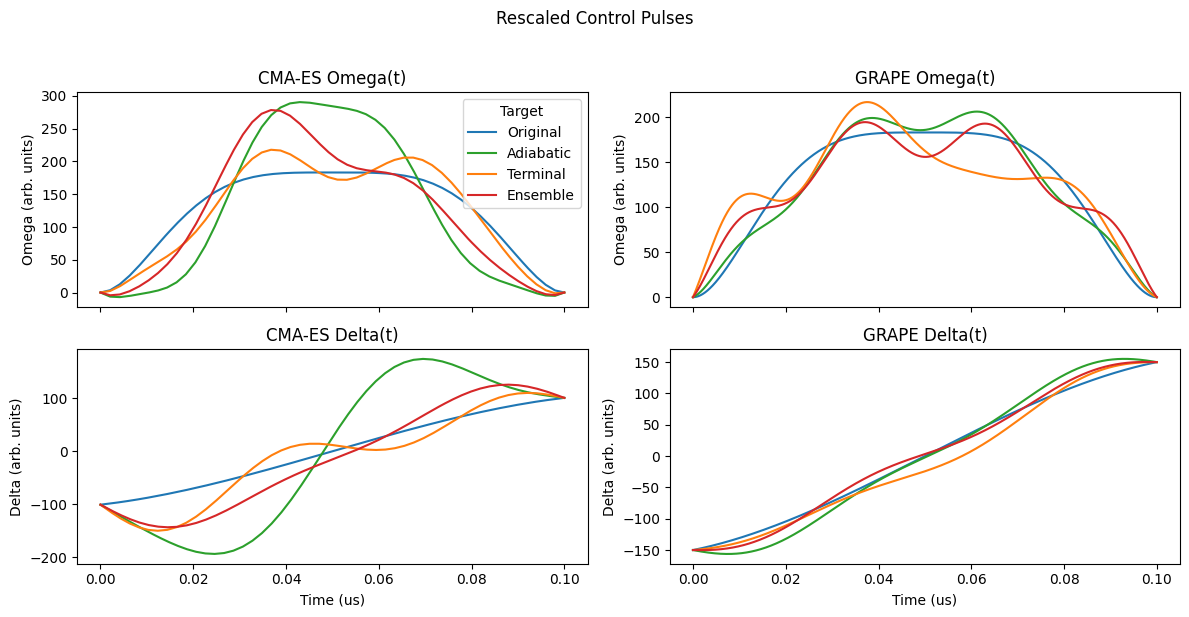

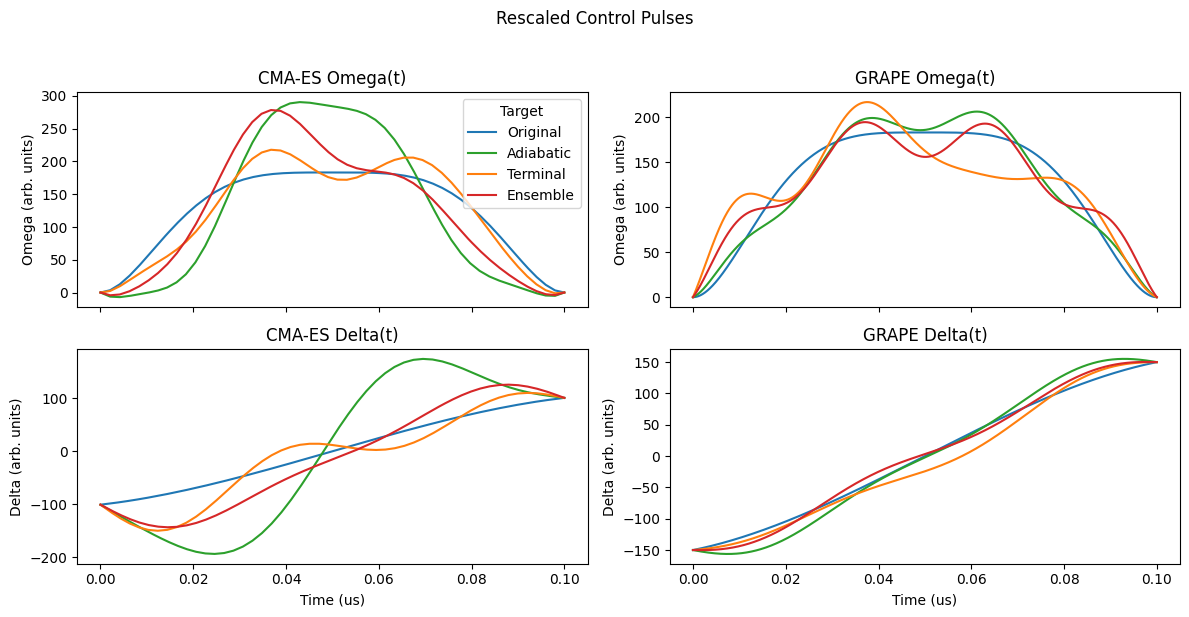

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

for col, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    algorithm_pulses = resampled_pulses.get(algorithm, {})
    for target in TARGETS:
        pulse_entry = algorithm_pulses.get(target)
        if not pulse_entry:
            continue
        time_axis = CANONICAL_T
        axes[0, col].plot(time_axis, pulse_entry['omega'], color=color_for(target), label=display_name(target))
        axes[1, col].plot(time_axis, pulse_entry['delta'], color=color_for(target), label=display_name(target))

    axes[0, col].set_title(f'{algorithm} Omega(t)')
    axes[0, col].set_ylabel('Omega (arb. units)')
    axes[1, col].set_title(f'{algorithm} Delta(t)')
    axes[1, col].set_ylabel('Delta (arb. units)')
    axes[1, col].set_xlabel(TIME_LABEL)

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    axes[0, 0].legend(handles, labels, loc='upper right', title='Target')

fig.suptitle('Rescaled Control Pulses', y=1.02)
fig.tight_layout()

overlay_path = OUTPUT_DIR / 'pulse_overlay.png'
fig.savefig(overlay_path, dpi=300, bbox_inches='tight')
print(f'Saved overlay figure to {overlay_path}')
fig

Saved population transfer figure to /home/yehon/projects/grape-crab-qoc/results/results/population_transfer.png
Saved trajectories to /home/yehon/projects/grape-crab-qoc/results/results/population_transfer.npz


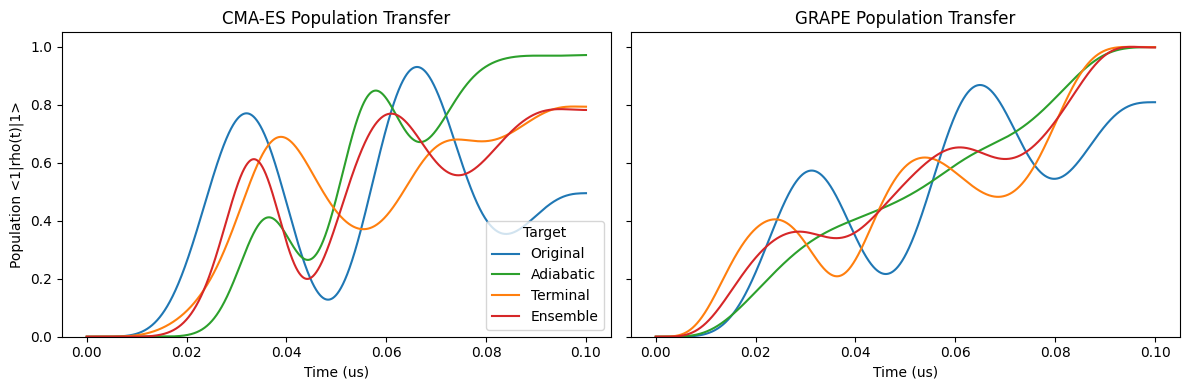

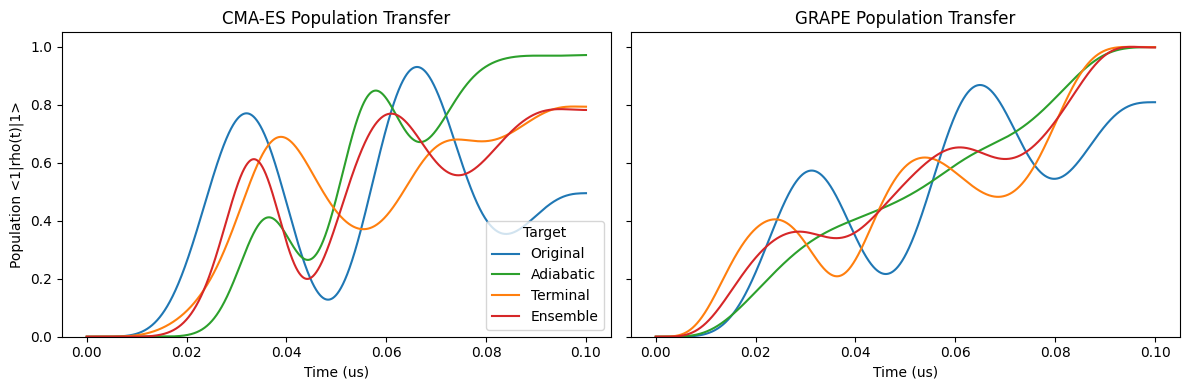

In [8]:
sx = qt.sigmax()
sz = qt.sigmaz()
ket0 = qt.basis(2, 0)
proj1 = qt.basis(2, 1) * qt.basis(2, 1).dag()


def make_interpolator(values: np.ndarray):
    values = np.asarray(values, dtype=float)

    def coefficient(t, _=None):
        return np.interp(t, CANONICAL_T, values)

    return coefficient


population_trajectories: dict[str, dict[str, np.ndarray]] = defaultdict(dict)
population_rows: list[dict[str, float]] = []

for algorithm, targets_dict in resampled_pulses.items():
    for target in TARGETS:
        pulse_entry = targets_dict.get(target)
        if not pulse_entry:
            continue

        omega = pulse_entry['omega']
        delta = pulse_entry['delta']

        hamiltonian = [
            [0.5 * sx, make_interpolator(omega)],
            [0.5 * sz, make_interpolator(delta)],
        ]

        result = qt.sesolve(hamiltonian, ket0, CANONICAL_T, e_ops=[proj1])
        population = np.clip(np.real(result.expect[0]), 0.0, 1.0)

        population_trajectories[algorithm][target] = population
        population_rows.append({
            'algorithm': algorithm,
            'target': target,
            'final_population': population[-1],
            'max_population': population.max(),
        })

population_fig, population_axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for col, algorithm in enumerate(['CMA-ES', 'GRAPE']):
    ax = population_axes[col]
    trajectories = population_trajectories.get(algorithm, {})
    for target in TARGETS:
        population = trajectories.get(target)
        if population is None:
            continue
        ax.plot(CANONICAL_T, population, color=color_for(target), label=display_name(target))

    ax.set_title(f'{algorithm} Population Transfer')
    ax.set_xlabel(TIME_LABEL)
    if col == 0:
        ax.set_ylabel('Population <1|rho(t)|1>')
    ax.set_ylim(0.0, 1.05)

handles, labels = population_axes[0].get_legend_handles_labels()
if handles:
    population_axes[0].legend(handles, labels, loc='lower right', title='Target')

population_fig.tight_layout()

population_path = OUTPUT_DIR / 'population_transfer.png'
population_fig.savefig(population_path, dpi=300, bbox_inches='tight')
print(f'Saved population transfer figure to {population_path}')

population_summary_df = pd.DataFrame(population_rows)
population_summary_df

population_npz = {'t': CANONICAL_T}
for algorithm, trajectories in population_trajectories.items():
    for target, values in trajectories.items():
        population_npz[slugify(algorithm, target, 'population')] = values
np.savez(OUTPUT_DIR / 'population_transfer.npz', **population_npz)
print(f"Saved trajectories to {OUTPUT_DIR / 'population_transfer.npz'}")

population_fig

Saved CMA-ES Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/cma_es_bloch_trajectories.png
Saved GRAPE Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/results/grape_bloch_trajectories.png


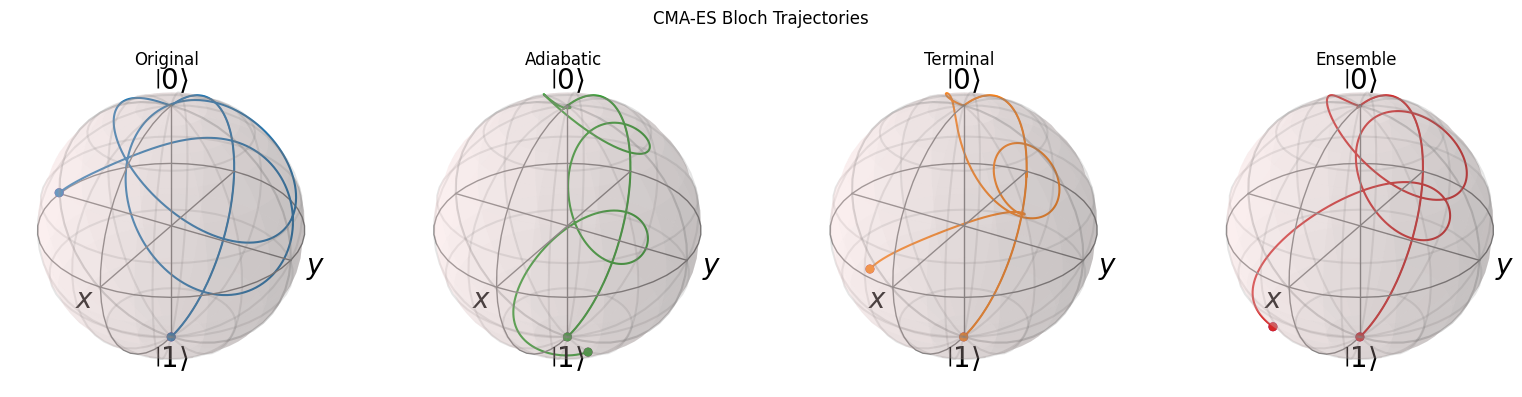

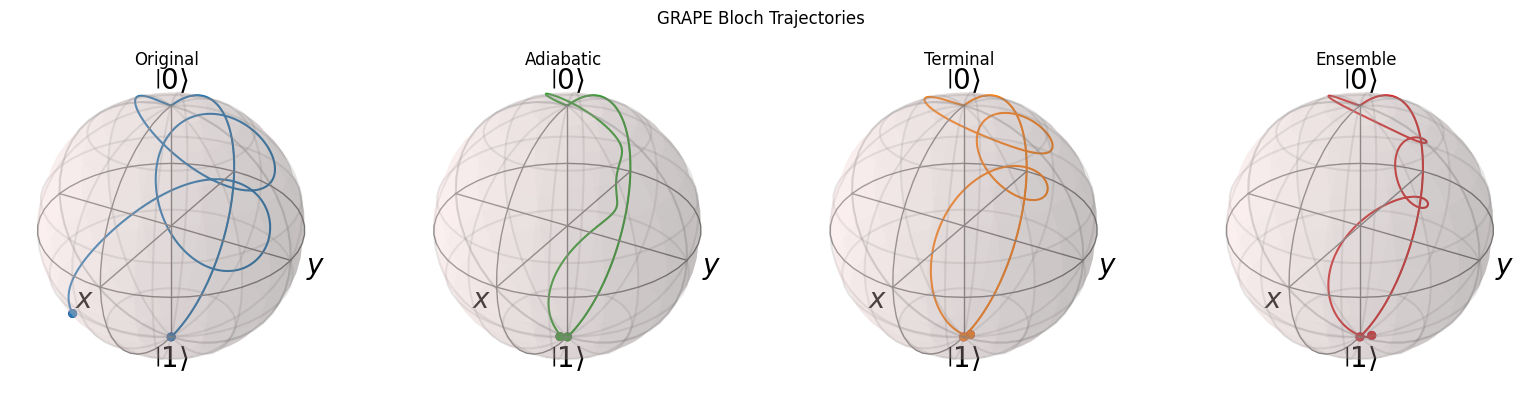

(<Figure size 1600x400 with 4 Axes>, <Figure size 1600x400 with 4 Axes>)

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sy = qt.sigmay()
GROUND_COLOR = '#800080'


def simulate_bloch_trajectory(algorithm: str, target: str):
    pulses = resampled_pulses.get(algorithm, {}).get(target)
    if not pulses:
        return None

    omega = pulses['omega']
    delta = pulses['delta']

    hamiltonian = [
        [0.5 * sx, make_interpolator(omega)],
        [0.5 * sz, make_interpolator(delta)],
    ]

    result = qt.sesolve(hamiltonian, ket0, CANONICAL_T)
    states = result.states

    trajectory = {
        'sx': np.real(qt.expect(sx, states)),
        'sy': np.real(qt.expect(sy, states)),
        'sz': np.real(qt.expect(sz, states)),
    }

    field = np.vstack((omega, np.zeros_like(omega), delta))
    norms = np.linalg.norm(field, axis=0)
    ground_vec = np.zeros_like(field)
    mask = norms > 0
    ground_vec[:, mask] = -field[:, mask] / norms[mask]
    if np.any(~mask):
        ground_vec[:, ~mask] = np.array([[0.0], [0.0], [1.0]])

    trajectory['ground_sx'] = ground_vec[0]
    trajectory['ground_sy'] = ground_vec[1]
    trajectory['ground_sz'] = ground_vec[2]
    return trajectory


def plot_bloch_grid(algorithm: str):
    fig = plt.figure(figsize=(16, 4))
    axes = [
        fig.add_subplot(1, len(TARGETS), idx + 1, projection='3d')
        for idx in range(len(TARGETS))
    ]

    for idx, target in enumerate(TARGETS):
        ax = axes[idx]
        trajectory = simulate_bloch_trajectory(algorithm, target)
        if trajectory is None:
            ax.set_axis_off()
            ax.text2D(0.5, 0.5, 'Missing data', transform=ax.transAxes, ha='center', va='center')
            continue

        bloch = qt.Bloch(fig=fig, axes=ax)
        bloch.line_color = [color_for(target), GROUND_COLOR]
        bloch.line_width = [2.5, 1.5]
        bloch.point_color = [color_for(target), GROUND_COLOR]
        bloch.point_marker = ['o', 'o']
        bloch.point_size = [30, 30]

        bloch.add_points(
            [trajectory['sx'], trajectory['sy'], trajectory['sz']],
            meth='l',
        )
        bloch.add_points(
            [[trajectory['sx'][-1]], [trajectory['sy'][-1]], [trajectory['sz'][-1]]],
        )
        bloch.add_points(
            [trajectory['ground_sx'], trajectory['ground_sy'], trajectory['ground_sz']],
            meth='l',
        )
        bloch.add_points(
            [[trajectory['ground_sx'][-1]], [trajectory['ground_sy'][-1]], [trajectory['ground_sz'][-1]]],
        )
        bloch.render()
        ax.set_title(display_name(target))

    fig.suptitle(f'{algorithm} Bloch Trajectories')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


cma_fig = plot_bloch_grid('CMA-ES')
cma_path = OUTPUT_DIR / 'cma_es_bloch_trajectories.png'
cma_fig.savefig(cma_path, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch spheres to {cma_path}')


grape_fig = plot_bloch_grid('GRAPE')
grape_path = OUTPUT_DIR / 'grape_bloch_trajectories.png'
grape_fig.savefig(grape_path, dpi=300, bbox_inches='tight')
print(f'Saved GRAPE Bloch spheres to {grape_path}')

plt.show(cma_fig)
plt.show(grape_fig)

cma_fig, grape_fig